# Impact of model parameters on gas properties

In [1]:
%matplotlib widget
from jax import Array
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.cosmology import FlatLambdaCDM, Cosmology
from astropy.units import Unit
from astropy.constants import G
G = G.to("km2 Mpc Msun-1 s-2").value

from picasso import utils, nonthermal, polytrop

plt.rcParams.update(
    {
        "text.usetex": True,
        "text.latex.preamble": "\\usepackage{txfonts}",
        "font.family": "serif",
        "font.size": 12.0,
    }
)

In [2]:
class NFW:
    def __init__(
        self,
        MDelta: float,
        cDelta: float,
        Delta: str,
        z: float,
        cosmo: Cosmology,
    ):
        self.MDelta = MDelta
        self.cDelta = cDelta
        if Delta == "200c":
            mean_rho = 200 * cosmo.critical_density(z).to("Msun Mpc-3").value
        elif Delta == "500c":
            mean_rho = 500 * cosmo.critical_density(z).to("Msun Mpc-3").value
        else:
            raise ValueError(
                f"{Delta=} not supported yet, must be either '200c' or '500c'"
            )
        self.RDelta = (3 * MDelta / (4 * jnp.pi * mean_rho)) ** (1 / 3)
        self.Rs = self.RDelta / cDelta
        rho0_denum = 4 * jnp.pi * self.Rs**3
        rho0_denum *= jnp.log(1 + cDelta) - cDelta / (1 + cDelta)
        self.rho0 = MDelta / rho0_denum

    def density(self, r: Array) -> Array:
        """NFW density profile
        Parameters
        ----------
        r : Array [Mpc]
            Radius
        Returns
        -------
        Array [Msun Mpc-3]
            Density at radius `r`
        """
        return self.rho0 / (r / self.Rs * (1 + r / self.Rs) ** 2)

    def enclosed_mass(self, r: Array) -> Array:
        """Enclosed mass profile
        Parameters
        ----------
        r : Array [Mpc]
            Radius
        Returns
        -------
        Array [Msun]
            Enclosed mass at radius `r`
        """
        prefact = 4 * jnp.pi * self.rho0 * self.Rs**3
        return prefact * (jnp.log(1 + r / self.Rs) - r / (r + self.Rs))

    def potential(self, r: Array) -> Array:
        """Potential profile
        Parameters
        ----------
        r : Array [Mpc]
            Radius
        Returns
        -------
        Array [km2 s-2]
            Potential at radius `r`
        """
        # G = G.to("km2 Mpc Msun-1 s-2").value
        prefact = -4 * jnp.pi * G * self.rho0 * self.Rs**3
        return prefact * jnp.log(1 + r / self.Rs) / r


# Polytropic gas model and non-thermal pressure fraction with varying parameters

## Polytropic gas model

The polytropic gas model can be written as:

$$
\rho(\phi) = \rho_0 \theta^{\Gamma(r) / (\Gamma(r) - 1)}(\phi), \\[10pt]
P(\phi) = P_0 \theta^{1 / (\Gamma(r) - 1)}(\phi),
$$
where $\phi$ is the halo's gravitational potential, and
$$
\theta(\phi) = 1 - \theta_0 (\phi - \phi_0),
$$

The gas polytropic index, $\Gamma$, is allowed to vary with radius as:

$$
\Gamma(r) = 
\begin{cases}
\begin{aligned}
    & \; 1 + (\Gamma_0 - 1) \frac{1}{1 + e^{-x}} & c_\Gamma \geqslant 0; \\
    & \; \Gamma_0 + (\Gamma_0 - 1) \left(1 - \frac{1}{1 + e^{x}}\right) & c_\Gamma < 0, \\
\end{aligned}
\end{cases}
$$

with $x \equiv r / (c_\gamma R_{500c})$.

→ the model has five parameters: $(\rho_0, P_0)$ are the central value of gas density and pressure, $\Gamma_0$ is the asymptotic value of the polytropic index as $r \rightarrow \infty$, $c_\gamma$ is the polytropic concentration ($c_\gamma = 0$ implies $\Gamma(r) = \Gamma_0$), and $\theta_0$ is a shape parameter.

## Non-thermal pressure fraction

We further write the fraction of non-thermal pressure as a power-law of radius, plus a constant plateau:

$$
f_{\rm nt}(r) = a_{\rm nt} + (b_{\rm nt} - a_{\rm nt}) \left(\frac{r}{2r_{500c}}\right)^{c_{\rm nt}}
$$

→ This adds three parameters to our gas model:  $a_{\rm nt}$ is the central value of non-thermal pressure fraction, $b_{\rm nt}$ is the non-thermal pressure fraction at $r=2r_{500c}$, and $c_{\rm nt}$ is the power law evolution with radius.

Let's vary each parameter one at a time and look at the impact on the gas properties, for an NFW halo:

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1721841355.729852 11790205 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1721841355.745216 11790205 service.cc:145] XLA service 0x1692c8fa0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721841355.745226 11790205 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1721841355.746656 11790205 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1721841355.746671 11790205 mps_client.cc:384] XLA backend will use up to 22906109952 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



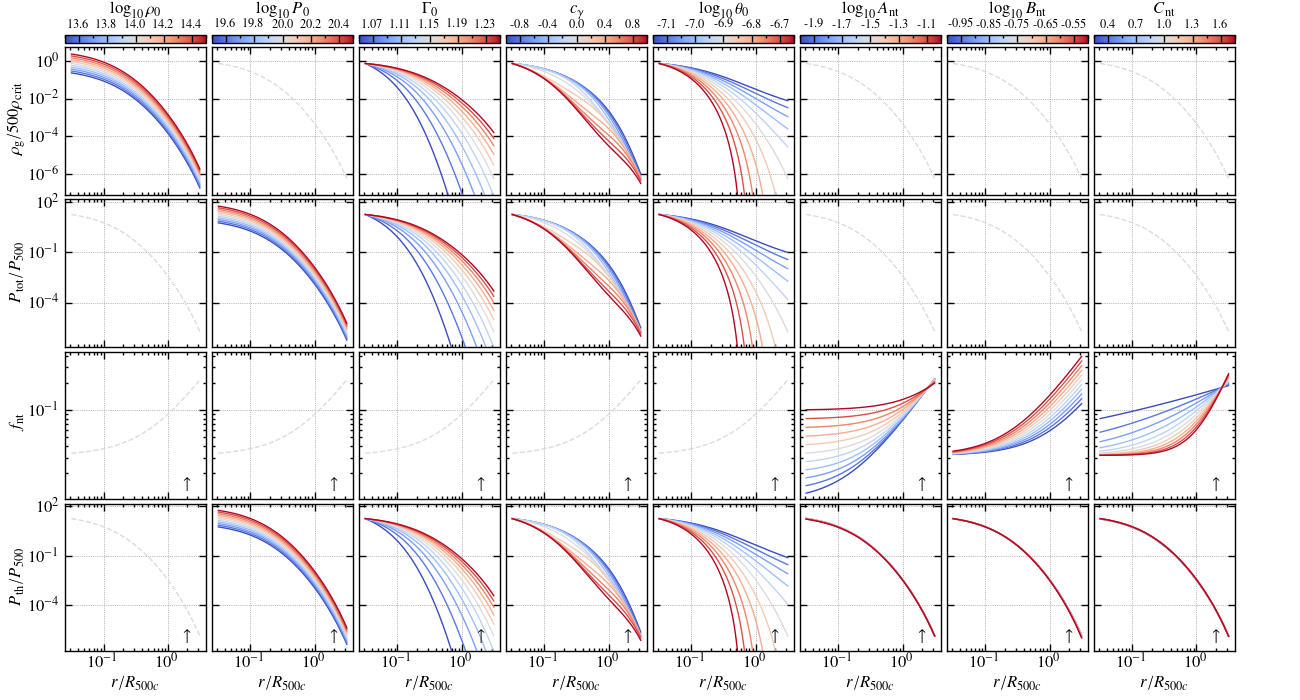

In [3]:
param_names = ["rho_0", "P_0", "Gamma_0", "c_gamma", "theta_0", "a", "b", "c"]
param_latex = ["$\\log_{10} \\rho_0$", "$\\log_{10} P_0$", "$\\Gamma_0$", "$c_\\gamma$", "$\\log_{10} \\theta_0$", "$\\log_{10} A_{\\rm nt}$", "$\\log_{10} B_{\\rm nt}$", "$C_{\\rm nt}$"]
params_fix = {
    "rho_0": 14.0,
    "P_0": 20.0,
    "Gamma_0": 1.15,
    "c_gamma": 0.0,
    "theta_0": -6.9,
    "a": -1.5,
    "b": -0.75,
    "c": 1.0
}
params_var = {
    "rho_0": np.linspace(13.5, 14.5, 11), 
    "P_0": np.linspace(19.5, 20.5, 11),
    "Gamma_0": np.linspace(1.05, 1.25, 11),
    "c_gamma": np.linspace(-1.0, 1.0, 11),
    "theta_0": np.linspace(-7.15, -6.65, 11),
    "a": np.linspace(-2.0, -1.0, 11),
    "b": np.linspace(-1.0, -0.5, 11),
    "c": np.linspace(0.25, 1.75, 11),
}
impacts = {
    "rho_0": [0],
    "P_0": [1, 3],
    "Gamma_0": [0, 1, 3],
    "c_gamma": [0, 1, 3],
    "theta_0": [0, 1, 3],
    "a": [2, 3],
    "b": [2, 3],
    "c": [2, 3],
}
n_p = len(param_names)

M500c = 3.5e14  # h-1 Msun
c500c = 5.0
z = 0.0
cosmo = FlatLambdaCDM(70.0, 0.3)
nfw = NFW(M500c / 0.7, c500c, "500c", 0.0, cosmo)
R500c = nfw.RDelta  # Mpc
r_R500c = jnp.logspace(-1.5, 0.5, 128)
phi = nfw.potential(r_R500c * R500c)
phi -= phi.min()
rho500 = 500 * cosmo.critical_density(z).to("Msun/Mpc3").value / (cosmo.h ** 2)
p500 = (
    1.65e-3 * cosmo.efunc(z) ** (8/3)
    * (M500c / (3e14 * 0.7)) ** (2/3)
    * (cosmo.h / 0.7) ** 2
) * Unit("keV cm-3").to("Msun Mpc-3 km2 s-2")

cmapname="coolwarm"
fig = plt.figure(figsize=(13, 7))
gs = mpl.gridspec.GridSpec(5, n_p, height_ratios=[0.05, 0.975, 0.975, 0.975, 0.975])
cb_axs = [fig.add_subplot(gs[i]) for i in range(n_p)]
axs = np.array([
    [fig.add_subplot(gs[i+1*n_p]) for i in range(n_p)],
    [fig.add_subplot(gs[i+2*n_p]) for i in range(n_p)],
    [fig.add_subplot(gs[i+3*n_p]) for i in range(n_p)],
    [fig.add_subplot(gs[i+4*n_p]) for i in range(n_p)],
])

par_vec_fix = params_fix.copy()
for p in ["rho_0", "P_0", "theta_0", "a", "b"]:
    par_vec_fix[p] = 10**par_vec_fix[p]
# rho_fix, Ptot_fix = polytrop.rho_P_g(phi, **par_vec_fix)
# axs[0, 1].loglog(r_R500c, rho_fix, lw=2, ls="--", color=plt.colormaps[cmapname](0.5))
# axs[1, 0].loglog(r_R500c, Ptot_fix, lw=2, ls="--", color=plt.colormaps[cmapname](0.5))

def compute_props(rho_0, P_0, Gamma_0, c_gamma, theta_0, a, b, c):
    rho, P_tot = polytrop.rho_P_g(phi, r_R500c, rho_0, P_0, Gamma_0, c_gamma, theta_0)
    f_nt = nonthermal.f_nt_generic(r_R500c / 2.5, a, b, c)
    return rho / rho500, P_tot / p500, f_nt, (P_tot / p500) * (1 - f_nt)

fixed_props = compute_props(**par_vec_fix)

for i_par_var, p_var in enumerate(param_names):
    norm = mpl.colors.Normalize(vmin=params_var[p_var].min(), vmax=params_var[p_var].max())
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=plt.colormaps[cmapname])
    cmap.set_array([])

    par_vecs = {p: jnp.ones(11) * params_fix[p] for p in param_names}
    par_vecs[p_var] = params_var[p_var]
    for p in ["rho_0", "P_0", "theta_0", "a", "b"]:
        par_vecs[p] = 10**par_vecs[p]
    for i_vec in range(11):
        props = compute_props(**{p: par_vecs[p][i_vec] for p in param_names})
        for i_prop, (prop, ax) in enumerate(zip(props, axs[:, i_par_var])):
            if i_prop in impacts[p_var]:
                ax.loglog(r_R500c, prop, color=cmap.to_rgba(params_var[p_var][i_vec]))
            else:
                if i_vec == 0:
                    ax.loglog(r_R500c, fixed_props[i_prop], "--", color=cmap.to_rgba(params_fix[p_var]))

    cb = fig.colorbar(cmap, cax=cb_axs[i_par_var], orientation="horizontal", location="top")  #, ticks=params_var[p_var][::2])
    cb_axs[i_par_var].set_xticks(params_var[p_var], minor=True)
    cb_axs[i_par_var].set_xticks(params_var[p_var][1::2], np.round(params_var[p_var][1::2], 2), fontsize=9)
    cb.set_label(param_latex[i_par_var])

for i_row, row in enumerate(axs):
    col_ref = [0, 1, 4, 1]
    ylim = jnp.array([ax.get_ylim() for ax in row]).flatten()
    for ax in row:
        if i_row == 2:
            ax.set_ylim(ylim.min(), ylim.max())
        else:
            ax.set_ylim(*row[col_ref[i_row]].get_ylim())
        if i_row == 3:
            ax.set_xlabel("$r / R_{500c}$")
        else:
            ax.set_xticklabels([])
        if i_row in [2, 3]:
            ax.text(2.0, 0.1, "$\\uparrow$", fontsize=12, ha="center", va="center", transform=ax.get_xaxis_transform())
    for ax in row[1:]:
        ax.set_yticklabels([])
for ax in axs.flatten():
    ax.xaxis.set_ticks_position("both")
    ax.yaxis.set_ticks_position("both")
    ax.grid(":", zorder=-5)

axs[0, 0].set_ylabel("$\\rho_{\\rm g} / 500 \\rho_{\\rm crit}$")
axs[1, 0].set_ylabel("$P_{\\rm tot} / P_{500}$")
axs[2, 0].set_ylabel("$f_{\\rm nt}$")
axs[3, 0].set_ylabel("$P_{\\rm th} / P_{500}$")
fig.align_labels()
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.07, hspace=0.04, wspace=0.04)
fig.savefig("impact_model_params.pdf")


## Radius-dependent polytropic index

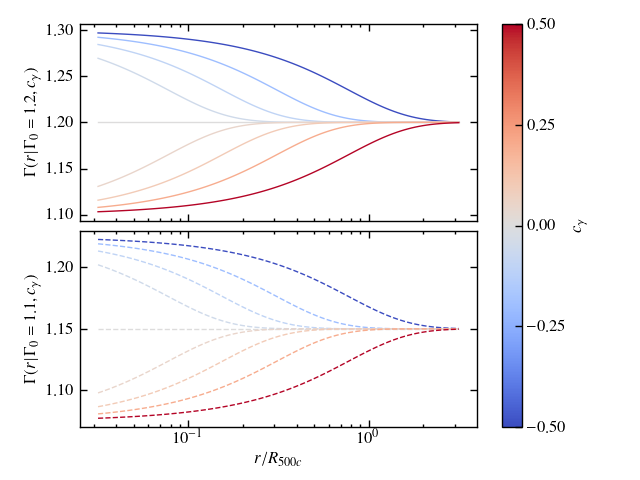

In [4]:
compute_gamma = polytrop.Gamma_r

r = jnp.logspace(-1.5, 0.5, 101)
c_gamma = jnp.array([-0.5, -0.2, -0.1, -0.05, 0.0, 0.05, 0.1, 0.2, 0.5])
cmapname="coolwarm"

norm = mpl.colors.Normalize(vmin=c_gamma.min(), vmax=c_gamma.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=plt.colormaps[cmapname])
cmap.set_array([])

fig, axs = plt.subplots(2, 1)
fig.subplots_adjust(hspace=0.05, top=0.95)
for i, c in enumerate(c_gamma):
    color = cmap.to_rgba(c)
    axs[0].semilogx(r, compute_gamma(r, 1.20, c), color=color)
    axs[1].semilogx(r, compute_gamma(r, 1.15, c), "--", color=color)
axs[1].set_xlabel("$r / R_{500c}$")
axs[0].set_xticklabels([])
axs[0].set_ylabel("$\\Gamma(r \\, | \\, \\Gamma_0 = 1.2, c_\\gamma)$")
axs[1].set_ylabel("$\\Gamma(r \\, | \\, \\Gamma_0 = 1.1, c_\\gamma)$")

cb = fig.colorbar(cmap, ax=axs)
cb.set_ticks(jnp.linspace(c_gamma.min(), c_gamma.max(), 5))
cb.set_label("$c_\\gamma$")

for ax in axs:
    ax.xaxis.set_ticks_position("both")
    ax.yaxis.set_ticks_position("both")
fig.align_labels()
fig.savefig("./gamma_r.pdf")
